# Modelling Baseline

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

In [42]:
df = pd.read_csv('../data/raw/ccm_rul_dataset.csv')
df.head()

,date,"workpiece_weight, tonn",steel_type,doc_requirement,cast_in_row,workpiece_slice_geometry,alloy_type,"steel_weight_theoretical, tonn","slag_weight_close_grab1, tonn","metal_residue_grab1, tonn",...,"Al, %","Ca, %","N, %","Pb, %","Mg, %","Zn, %",sleeve,num_crystallizer,num_stream,RUL
0,2020-01-05,144.9,Arm240,DOC 34028-2016,4,150x150,open,145.3,1.8,0.4,...,0.0022,0.0008,0.0085,0.0,0.0,0.0,30012261,22,4,384.0
1,2020-01-05,165.9,St3sp,Contract,10,150x150,open,166.3,1.8,0.4,...,0.0028,0.0004,0.0049,0.0,0.0,0.0,30013346,2,1,1037.0
2,2020-01-05,168.0,Arm240,DOC 34028-2016,5,150x150,open,168.4,1.8,0.4,...,0.0031,0.0011,0.0068,0.0,0.0,0.0,30012261,22,4,355.0
3,2020-01-05,170.1,St3sp,Contract,7,150x150,open,170.5,1.8,0.4,...,0.0034,0.0005,0.0051,0.0,0.0,0.0,30012261,22,4,300.0
4,2020-01-05,163.8,St3sp,Contract,12,150x150,open,164.2,1.8,0.4,...,0.0032,0.0004,0.0038,0.0,0.0,0.0,30012261,22,4,164.0


technical_trim, tonn                      0.995658
residuals_grab2, tonn                     0.970691
Sn, %                                     0.871222
Ce, %                                     0.310233
quantity, tonn                            0.129292
kind                                      0.129292
grab1_num                                 0.015483
RUL                                       0.012798
resistance, tonn                          0.012798
temperature_measurement2, Celsius deg.    0.001485
dtype: float64


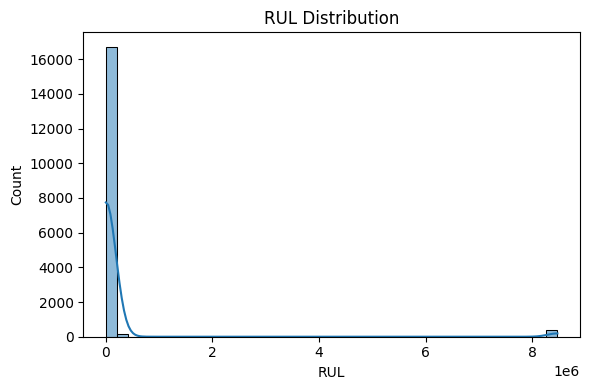

In [43]:
# Missing overview
missing = df.isna().mean().sort_values(ascending=False)
print(missing[missing > 0].head(10))

# Target distribution
plt.figure(figsize=(6,4))
sns.histplot(df["RUL"], bins=40, kde=True)
plt.title("RUL Distribution")
plt.tight_layout()
plt.show()

In [44]:
df_labeled = df.dropna(subset=["RUL"]).copy()

print("Before:", df.shape)
print("After :", df_labeled.shape)

df = df_labeled.copy()

Before: (17503, 57)
After : (17279, 57)


In [45]:
GROUP_COLS = ["num_crystallizer", "num_stream"]

# --- Physical deltas ---
df["steel_weight_error"] = (
    df["steel_weight, tonn"] - df["steel_weight_theoretical, tonn"]
)

df["total_residuals"] = (
    df["slag_weight_close_grab1, tonn"].fillna(0)
    + df["metal_residue_grab1, tonn"].fillna(0)
    + df["residuals_grab2, tonn"].fillna(0)
)

df["temp_delta_measurement"] = (
    df["temperature_measurement2, Celsius deg."]
    - df["temperature_measurement1, Celsius deg."]
)

df["cooling_efficiency"] = (
    df["water_temperature_delta, Celsius deg."]
    / df["water_consumption, liter/minute"].replace(0, np.nan)
)

# --- Rolling stats (past only) ---
ROLL_COLS = [
    "steel_temperature_grab1, Celsius deg.",
    "water_temperature_delta, Celsius deg.",
    "alloy_speed, meter/minute",
    "swing_frequency, amount/minute",
    "resistance, tonn"
]
ROLL_WINDOWS = [3, 5]

for col in ROLL_COLS:
    for w in ROLL_WINDOWS:
        df[f"{col}_roll_mean_{w}"] = (
            df.groupby(GROUP_COLS)[col]
              .transform(lambda x: x.rolling(w, min_periods=1).mean())
        )
        df[f"{col}_roll_std_{w}"] = (
            df.groupby(GROUP_COLS)[col]
              .transform(lambda x: x.rolling(w, min_periods=1).std())
        )

# --- Trend (finite diff) ---
for col in [
    "steel_temperature_grab1, Celsius deg.",
    "water_temperature_delta, Celsius deg.",
    "alloy_speed, meter/minute",
]:
    df[f"{col}_diff"] = df.groupby(GROUP_COLS)[col].diff()

# --- Chemistry aggregation ---
chem_cols = [c for c in df.columns if c.endswith(", %")]
df["chem_sum"] = df[chem_cols].sum(axis=1)
df["chem_std"] = df[chem_cols].std(axis=1)


In [46]:
TARGET = "RUL"
DROP_COLS = ["date"]

X = df.drop(columns=[TARGET] + DROP_COLS)
y = df[TARGET]

# Identify column types
num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(exclude="number").columns.tolist()

print("Numeric:", len(num_cols), "Categorical:", len(cat_cols))

Numeric: 75 Categorical: 9


In [47]:
tscv = TimeSeriesSplit(n_splits=5)
train_idx, val_idx = list(tscv.split(X))[-1]

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

X_train.shape, X_val.shape

((14400, 84), (2879, 84))

In [48]:
from sklearn.impute import SimpleImputer


numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("var", VarianceThreshold(threshold=1e-4)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop"
)


In [49]:
def eval_basic(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
    }

def rul_asymmetric_error(y_true, y_pred, over_penalty=2.0):
    err = y_pred - y_true
    return np.mean(np.where(err > 0, over_penalty * err, np.abs(err)))


#### Baseline 1 — Ridge Regression (Linear, Interpretable)

In [51]:
ridge = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_val)

print("Ridge:", eval_basic(y_val, pred_ridge),
      "Asym:", rul_asymmetric_error(y_val.values, pred_ridge))

Ridge: {'MAE': 151972.27523600624, 'RMSE': 181338.73796615735} Asym: 303654.7476356764


#### Random Forest (robust non-linear)

In [52]:
rf = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

print("RF:", eval_basic(y_val, pred_rf),
      "Asym:", rul_asymmetric_error(y_val.values, pred_rf))

RF: {'MAE': 2592.5637891225197, 'RMSE': 3325.817654710361} Asym: 4170.668059674495


#### Gradient Boosting (strong default)

In [ ]:
gbr = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ))
])

gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_val)

print("GBR:", eval_basic(y_val, pred_gbr),
      "Asym:", rul_asymmetric_error(y_val.values, pred_gbr))